# 1. Using GPT to generate text

In [1]:
import torch
from tqdm import tqdm
from gpt.gpt_model import GPTModel
from config.config import GPT_CONFIG_124M

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

We reduce the context length (context_length) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

* Next, we use the generate_text_simple function from the previous chapter to generate text

* In addition, we define two convenience functions, text_to_token_ids and token_ids_to_text, for converting between token and text representations that we use throughout this chapter

In [2]:
import tiktoken
from utils.utils import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


---
# 2. Calculating the text generation loss: cross-entropy and perplexity

In [3]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

Feeding the inputs to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each

In [4]:
with torch.no_grad():
    logits = model(inputs)

# Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


We can apply argmax function to convert the probability scores into predicted token IDs

In [5]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [6]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


To train the model, we need to know how far it is away from the correct predictions (targets)

In [7]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


* We want to maximize all these values, bringing them close to a probability of 1
* In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself

In [8]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


Next, we compute the average log probability:

In [9]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


* The goal is to make this average log probability as large as possible by optimizing the model weights
* Due to the log, the largest possible value is 0, and we are currently far away from 0
---

* In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0
* The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning

In [10]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


PyTorch already implements a cross_entropy function that carries out the previous steps

* Before we apply the cross_entropy function, let's check the shape of the logits and targets

In [11]:
print("Logits Shape: ", logits.shape)
print("Targets Shape: ", targets.shape)

Logits Shape:  torch.Size([2, 3, 50257])
Targets Shape:  torch.Size([2, 3])


For the cross_entropy function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:

In [12]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits: ", logits_flat.shape)
print("Flattened targets: ", targets_flat.shape)

Flattened logits:  torch.Size([6, 50257])
Flattened targets:  torch.Size([6])


* Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize
* The `cross_entropy` function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

In [13]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


## Perplexity
* A concept related to the cross-entropy loss is the perplexity of an LLM
* The perplexity is simply the exponential of the cross-entropy loss

> The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 52,918 words or tokens)

#### Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution

In [14]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


---
# 3. Calculating the training and validation set losses

We use a relatively small dataset for training the LLM (in fact, only one short story)

> FACT: Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens

In [15]:
import os

# we are going to use the same dataset from data loading
file_path = "../../data/the-verdict.txt"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        text_data = f.read()

In [16]:
text_data[:99]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no '

In [17]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


##### Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training

In [18]:
from data.dataloader import create_dataloader_v1

# train-test splitting
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    text=train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    text=val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [19]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [20]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


### We will implement a utility function to calculate the cross-entropy loss of a given batch
* In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader

In [21]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [22]:
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

model = model.to(device)
# model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123)

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using mps device.
Training loss: 10.98758316040039
Validation loss: 10.98110580444336


---
# 4. Training an LLM

In [25]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):

    # Initialize list to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train() # Set the model to training mode

        print(f"Epoch: {epoch+1}:")
        for input_batch, target_batch in tqdm(train_loader):
            # Reset the loss gradients from prev. batch iterations
            optimizer.zero_grad()

            # Note: that the input_batch and the target_batch are already in the designated device
            #       as seen in the code for calc_loss_batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()     # Compute loss gradients

            optimizer.step()    # Update Model weights using loss gradients

            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional Evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen




def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss




def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [26]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

end_time = time.time()

Epoch: 1:


 11%|█         | 1/9 [00:16<02:09, 16.14s/it]

Ep 1 (Step 000000): Train loss 9.817, Val loss 9.924


 67%|██████▋   | 6/9 [05:31<02:46, 55.61s/it]

Ep 1 (Step 000005): Train loss 8.066, Val loss 8.332


100%|██████████| 9/9 [07:15<00:00, 48.38s/it]


Every effort moves you,,,,,,,,,,,,.                                     
Epoch: 2:


 22%|██▏       | 2/9 [01:28<05:09, 44.21s/it]

Ep 2 (Step 000010): Train loss 6.619, Val loss 7.042


 78%|███████▊  | 7/9 [06:31<02:05, 62.95s/it]

Ep 2 (Step 000015): Train loss 6.046, Val loss 6.596


100%|██████████| 9/9 [08:59<00:00, 59.91s/it]


Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,, and,, the,, the, and,, and,,, the, and,,,,,,
Epoch: 3:


 33%|███▎      | 3/9 [02:52<06:13, 62.31s/it]

Ep 3 (Step 000020): Train loss 5.524, Val loss 6.508


 89%|████████▉ | 8/9 [07:26<00:52, 52.76s/it]

Ep 3 (Step 000025): Train loss 5.369, Val loss 6.378


100%|██████████| 9/9 [08:13<00:00, 54.82s/it]


Every effort moves you, and to the of the of the picture. Gis.                                     
Epoch: 4:


 44%|████▍     | 4/9 [04:04<05:12, 62.49s/it]

Ep 4 (Step 000030): Train loss 4.830, Val loss 6.263


100%|██████████| 9/9 [09:37<00:00, 64.12s/it]

Ep 4 (Step 000035): Train loss 4.586, Val loss 6.285


Every effort moves you of the "I the picture.                    "I"I the picture"I had the picture"I the picture and I had been the picture of
Epoch: 5:


 56%|█████▌    | 5/9 [03:22<02:49, 42.44s/it]

Ep 5 (Step 000040): Train loss 3.879, Val loss 6.130


100%|██████████| 9/9 [05:52<00:00, 39.13s/it]


Every effort moves you know he had been his pictures, and I felt it's by his last word.                   "Oh, and he had been the end, and he had been
Epoch: 6:


 11%|█         | 1/9 [00:36<04:52, 36.61s/it]

Ep 6 (Step 000045): Train loss 3.530, Val loss 6.183


 67%|██████▋   | 6/9 [04:19<02:18, 46.11s/it]

Ep 6 (Step 000050): Train loss 2.960, Val loss 6.123


100%|██████████| 9/9 [06:27<00:00, 43.06s/it]


Every effort moves you know it was his pictures--I glanced after him, I had the last word.        "Oh, and I was his pictures--I looked.   "I looked. "I looked. 
Epoch: 7:


 22%|██▏       | 2/9 [01:38<05:55, 50.84s/it]

Ep 7 (Step 000055): Train loss 2.832, Val loss 6.150


 78%|███████▊  | 7/9 [09:30<03:02, 91.31s/it]

Ep 7 (Step 000060): Train loss 2.104, Val loss 6.133


100%|██████████| 9/9 [12:11<00:00, 81.23s/it]


Every effort moves you know the picture to me--I glanced after him, and Mrs.  "I was no great, the fact, the fact that, the moment--as Jack himself, as his pictures--as of the picture--because he was a little
Epoch: 8:


 33%|███▎      | 3/9 [04:44<09:44, 97.39s/it]

Ep 8 (Step 000065): Train loss 1.691, Val loss 6.186


 89%|████████▉ | 8/9 [11:52<01:29, 89.85s/it]

Ep 8 (Step 000070): Train loss 1.391, Val loss 6.230


100%|██████████| 9/9 [13:27<00:00, 89.76s/it]


Every effort moves you?"  "Yes--quite insensible to the fact with a little: "Yes--and by me to me to have to see a smile behind his close grayish beard--as if he had the donkey. "There were days when I
Epoch: 9:


 44%|████▍     | 4/9 [05:54<07:09, 85.81s/it] 

Ep 9 (Step 000075): Train loss 1.059, Val loss 6.251


100%|██████████| 9/9 [16:21<00:00, 109.09s/it]

Ep 9 (Step 000080): Train loss 0.800, Val loss 6.278


Every effort moves you?"  "Yes--quite insensible to the fact with a laugh: "Yes--and by me!"  He laughed again, and threw back the window-curtains, I saw that, and down the room, and now
Epoch: 10:


 56%|█████▌    | 5/9 [13:27<10:53, 163.33s/it]

Ep 10 (Step 000085): Train loss 0.569, Val loss 6.373


100%|██████████| 9/9 [18:40<00:00, 124.48s/it]


Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I


In [27]:
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Training completed in 110.15 minutes.


In [28]:
# Save the final trained model to a file
model_save_path = "gpt_final_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to gpt_final_model.pth


In [29]:
# Load the trained model from file
loaded_model = GPTModel(GPT_CONFIG_124M)
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))
loaded_model.to(device)
loaded_model.eval()
print("Model loaded from", model_save_path)

Model loaded from gpt_final_model.pth


In [30]:
generate_and_print_sample(
    loaded_model,
    tokenizer,
    device,
    "The word, on Mrs. Thwing's"
)

The word, on Mrs. Thwing's the picture for nothing--I told Mrs. Stroud so when she began to stammer something about her poverty. I remember getting off a prodigious phrase about the honour being _mine_--because he didn't want to go on painting;


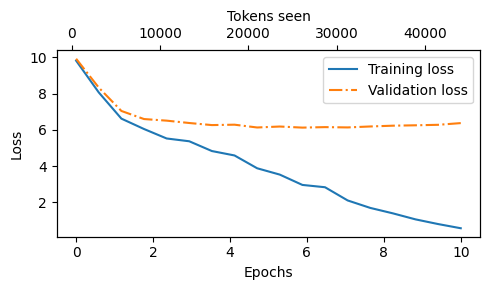

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.png")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)